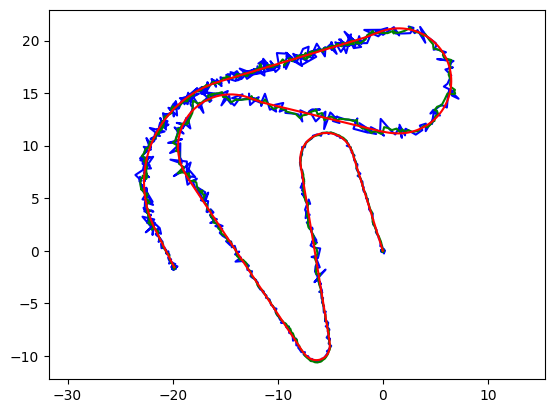

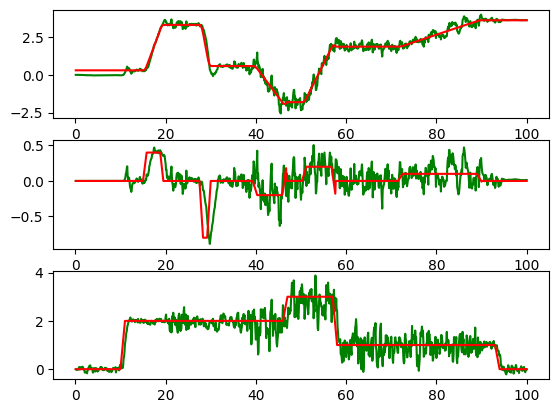

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/home/test/workspace/research_project_ws23/matlab_to_jupyter/xy.csv')
GT = {
    'x': data['GT_x'].to_numpy(),
    'y': data['GT_y'].to_numpy(),
    'alpha': data['GT_alpha'].to_numpy(),
    'Kr': data['GT_Kr'].to_numpy(),
    'v': data['GT_v'].to_numpy()
}
t = data['time'].to_numpy()
Ts = t[1] - t[0]
y = data[['Pos_x', 'Pos_y']].to_numpy()

# EKF
R = np.cov(y[:100, :].T)

qxy = 2E-4
qa = 1E-4
qKr = 5E-4
qv = 5E-3
GQG = np.diag([qxy, qxy, qa, qKr, qv])

Cj = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])

# Initializations
x_dach = np.array([y[0, 0], y[0, 1], 0, 0, 0])
P_dach = np.diag([0.1, 0.1, 1e-2, 1e-3, 1e-2])
N = len(y)
xP, yP, alpha, Kr, v = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

for k in range(N):
    dy = y[k, :].reshape(-1, 1) - Cj.dot(x_dach.reshape(-1, 1))
    M = Cj.dot(P_dach).dot(Cj.T) + R
    K = P_dach.dot(Cj.T).dot(np.linalg.inv(M))
    x_tilde = x_dach + K.dot(dy).flatten()
    P_tilde = (np.eye(len(x_dach)) - K.dot(Cj)).dot(P_dach)
    xP[k], yP[k], alpha[k], Kr[k], v[k] = x_tilde

    x_dach = np.array([
        xP[k] - v[k] * Ts * np.sin(alpha[k]),
        yP[k] + v[k] * Ts * np.cos(alpha[k]),
        alpha[k] + v[k] * Ts * Kr[k],
        Kr[k],
        v[k]
    ])

    Aj = np.array([
        [1, 0, -v[k] * Ts * np.cos(alpha[k]), 0, -Ts * np.sin(alpha[k])],
        [0, 1, -v[k] * Ts * np.sin(alpha[k]), 0, Ts * np.cos(alpha[k])],
        [0, 0, 1, v[k] * Ts, Kr[k] * Ts],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])

    P_dach = Aj @ (P_tilde + GQG) @ Aj.T

# Plotting
plt.figure(1)
plt.clf()
plt.plot(y[:, 0], y[:, 1], 'b-', xP, yP, 'g-', GT['x'], GT['y'], 'r-')
plt.axis('equal')

plt.figure(2)
plt.clf()
plt.subplot(311)
plt.plot(t, alpha, 'g-', t, GT['alpha'], 'r-')
plt.subplot(312)
plt.plot(t, Kr, 'g-', t, GT['Kr'], 'r-')
plt.subplot(313)
plt.plot(t, v, 'g-', t, GT['v'], 'r-')
plt.show()


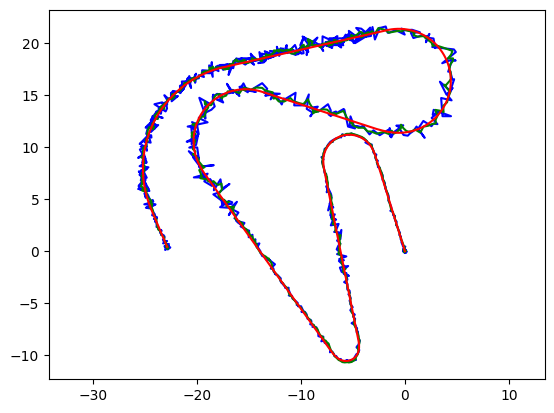

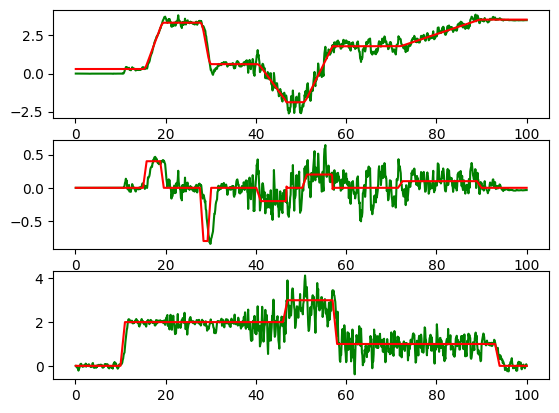

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def extract_ground_truth(data):
    return {
        'x': data['GT_x'].to_numpy(),
        'y': data['GT_y'].to_numpy(),
        'alpha': data['GT_alpha'].to_numpy(),
        'Kr': data['GT_Kr'].to_numpy(),
        'v': data['GT_v'].to_numpy()
    }

def initialize_parameters(data):
    t = data['time'].to_numpy()
    Ts = t[1] - t[0]
    y = data[['Pos_x', 'Pos_y']].to_numpy()

    R = np.cov(y[:100, :].T)
    GQG = np.diag([2E-4, 2E-4, 1E-4, 5E-4, 5E-3])
    Cj = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])
    x_dach = np.array([y[0, 0], y[0, 1], 0, 0, 0])
    P_dach = np.diag([0.1, 0.1, 1e-2, 1e-3, 1e-2])
    return t, Ts, y, R, GQG, Cj, x_dach, P_dach

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, Ts, y, R, GQG, Cj, x_dach, P_dach):
        self.Ts = Ts
        self.y = y
        self.R = R
        self.GQG = GQG
        self.Cj = Cj
        self.x_dach = x_dach
        self.P_dach = P_dach
        self.N = len(y)
        self.xP = np.zeros(self.N)
        self.yP = np.zeros(self.N)
        self.alpha = np.zeros(self.N)
        self.Kr = np.zeros(self.N)
        self.v = np.zeros(self.N)

    def run(self):
        for k in range(self.N):
            # Prediction Update
            dy = self.y[k, :].reshape(-1, 1) - self.Cj.dot(self.x_dach.reshape(-1, 1))
            M = self.Cj.dot(self.P_dach).dot(self.Cj.T) + self.R
            K = self.P_dach.dot(self.Cj.T).dot(np.linalg.inv(M))
            x_tilde = self.x_dach + K.dot(dy).flatten()
            P_tilde = (np.eye(len(self.x_dach)) - K.dot(self.Cj)).dot(self.P_dach)

            # Ensure x_tilde is unpacked correctly
            if len(x_tilde) == 5:
                self.xP[k], self.yP[k], self.alpha[k], self.Kr[k], self.v[k] = x_tilde
            else:
                raise ValueError("Expected x_tilde to have 5 elements, got {}".format(len(x_tilde)))

            # State Update
            self.x_dach = np.array([
                self.xP[k] - self.v[k] * self.Ts * np.sin(self.alpha[k]),
                self.yP[k] + self.v[k] * self.Ts * np.cos(self.alpha[k]),
                self.alpha[k] + self.v[k] * self.Ts * self.Kr[k],
                self.Kr[k],
                self.v[k]
            ])

            # Jacobian Matrix
            Aj = np.array([
                [1, 0, -self.v[k] * self.Ts * np.cos(self.alpha[k]), 0, -self.Ts * np.sin(self.alpha[k])],
                [0, 1, -self.v[k] * self.Ts * np.sin(self.alpha[k]), 0, self.Ts * np.cos(self.alpha[k])],
                [0, 0, 1, self.v[k] * self.Ts, self.Kr[k] * self.Ts],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 1]
            ])

            # Covariance Update
            self.P_dach = Aj @ (P_tilde + self.GQG) @ Aj.T

        return self.xP, self.yP, self.alpha, self.Kr, self.v


def plot_results(t, y, GT, xP, yP, alpha, Kr, v):
    plt.figure(1)
    plt.clf()
    plt.plot(y[:, 0], y[:, 1], 'b-', xP, yP, 'g-', GT['x'], GT['y'], 'r-')
    plt.axis('equal')

    plt.figure(2)
    plt.clf()
    plt.subplot(311)
    plt.plot(t, alpha, 'g-', t, GT['alpha'], 'r-')
    plt.subplot(312)
    plt.plot(t, Kr, 'g-', t, GT['Kr'], 'r-')
    plt.subplot(313)
    plt.plot(t, v, 'g-', t, GT['v'], 'r-')
    plt.show()

# Main script
file_path = '/home/test/workspace/research_project_ws23/matlab_to_jupyter/xy2.csv'
data = load_data(file_path)
GT = extract_ground_truth(data)
t, Ts, y, R, GQG, Cj, x_dach, P_dach = initialize_parameters(data)
ekf = ExtendedKalmanFilter(Ts, y, R, GQG, Cj, x_dach, P_dach)
xP, yP, alpha, Kr, v = ekf.run()
plot_results(t, y, GT, xP, yP, alpha, Kr, v)
